# NTM - partition visualiser
## Enrico

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import py_fort_myrmidon as fm
import datetime
import networkx as nx
import community
import statistics
import scipy.stats as stats
from os import listdir
from datetime import datetime, date, timedelta
import pickle

In [5]:
working_dir = '/media/eg15396/EG_DATA-7/NTM/'
myrm_list = sorted([ s for s in listdir(working_dir) if s[15:17] == '.m'])

## Property calculator

In [9]:
# function to compute netowrk properties
def G_prop(G, start, time_win, max_gap, name):
    
    # compute connencted components
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)

    # Define Giant Component
    GC = G.subgraph(Gcc[0])
    
    # Best partition Louvian Method
    best_partition = community.best_partition(G, weight='weight', randomize=False)
    best_partition_CC = community.best_partition(GC, weight='weight', randomize=False)
    return {'rep': int(name[8:10]),
            'exp': name[11:15],
            'start': fm.Time.ToDateTime(start), 
            'time_win': time_win, 
            'max_gap': max_gap,
            'GC': GC.number_of_nodes(),
            'ants': G.number_of_nodes(),
            'partition': best_partition_CC,
            'MOD': community.modularity(best_partition, G),
            'cMOD': community.modularity(best_partition_CC, GC),
            }

# initialise data-frame with properties
prop_df = pd.DataFrame(columns=G_prop(nx.Graph(np.eye(2)),fm.Time.Now(),1,1,myrm_list[0]).keys())

## Compute graph

In [10]:
# Function to compute the cumulative interaction function
def compute_G(exp, start, end, min_cum_duration, frm_rate, link_type):
    
    # Number of ants
    N_ants = len(exp.Ants)    

    # initialise adj-matrix
    adj_mat = np.zeros((N_ants, N_ants))

    # Dictionary to convert timestamp of frame into corresponding frame number starting from 1 (with frame#1 at 'start' time)
    TimeToFrame = {fm.Time.ToTimestamp(frm[0].FrameTime): i + 1 for i,frm in enumerate(fm.Query.CollideFrames(exp,start=start,end=end))}

    # Populate network
    for i in fm.Query.ComputeAntInteractions(exp,start=start,end=end,maximumGap=fm.Duration(max_gap*10**9),
                                            reportFullTrajectories= False)[1]:
        
        # Focus on Nest zone (id=1)
        if (1 in i.Trajectories[1].Zones):
            
            if link_type == 'length_inter':
            # OPT1
            # WEIGHTS: cumulative interaction time
                adj_mat[i.IDs[0]-1, i.IDs[1]-1] += (TimeToFrame[fm.Time.ToTimestamp(i.End)] - TimeToFrame[fm.Time.ToTimestamp(i.Start)]) * 1 / frm_rate
            elif link_type == '#inter':
            # OPT2
            # WEIGHTS: number of interactions
                adj_mat[i.IDs[0]-1, i.IDs[1]-1] += 1
            else:
                raise TypeError('"link_type" not valid')
                

    # interaction filtering (remove weak connections)
    adj_mat[adj_mat <  min_cum_duration] = 0

    # network build
    G = nx.Graph(adj_mat)

    # store inverse of weights
    nx.set_edge_attributes(G, 
                           {(i,j): 1/adj_mat[j,i] if adj_mat[j,i]>0 else 0 for i in range(len(adj_mat)) for j in range(i)},
                           'inv_weight')
    return G

## Loop files

In [64]:
## ========= PARAMETERS========= 
# Frame rate
frm_rate = 6

# max gap for different interactions
max_gap = 10

# minimum cumulative interaction duration (s)
min_cum_duration = 0 


# maximum gap (s) for interaction computation
for link_type in ['length_inter']:
    
    # initialise data-frame with properties
    prop_df = pd.DataFrame(columns=G_prop(nx.Graph(np.eye(2)),fm.Time.Now(),1,1,myrm_list[0]).keys())

    print(link_type)

    for myrm_file in myrm_list[30:31]:
        
        if int(myrm_file[8:10])==41: 
            continue

        print(myrm_file)

        # Open experiment file
        exp = fm.Experiment.Open(working_dir + myrm_file)

        ## ------ Time window ------ 
        # define time window of cumulative network
        start_date = (fm.Time.ToDateTime(fm.Query.GetDataInformations(exp).End) +
                     timedelta(days = -1)).strftime("%Y-%m-%d")

        # ======== Total cumulative time window ========
        # cumulative time window (s)
        time_win = 60 * 60 * 12

        start = fm.Time(datetime.fromisoformat(start_date + 'T09:00:00'))  
        end = start.Add(fm.Duration(time_win * 10**9))

        # ======== 4H window ========
        time_win = 60 * 60 * 4
        for tw in range(1):
            print('4h slot ' + str(tw + 1))
            s = start.Add(fm.Duration(tw * time_win * 10**9))
            e = start.Add(fm.Duration((tw + 1) * time_win * 10**9))

            # Compute network
            G = compute_G(exp, s, e, min_cum_duration, frm_rate, link_type)

            # Compute properties
            prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)
            

    # Save
    #a_file = open('data/prop_data_12_6_4_3_2_1_' + link_type + '_nest.pkl', "wb")
    #pickle.dump(prop_df, a_file)
    #a_file.close()

prop_df

length_inter
EG_NTM_s18_DENa.myrmidon
4h slot 1


/tmp/ipykernel_1951/3739603660.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prop_df = prop_df.append(G_prop(G, s, time_win, max_gap, myrm_file), ignore_index=True)


,rep,exp,start,time_win,max_gap,GC,ants,partition,MOD,cMOD
0,18,DENa,2021-10-02 09:00:00,14400,10,146,151,"{0: 0, 1: 1, 2: 2, 3: 1, 4: 1, 5: 0, 6: 0, 7: ...",0.290975,0.313248


In [79]:
# Heatmap stack calculator

def compute_HM_stack(exp, start, end):
    
    # Number of ants
    N_ants = len(exp.Ants)    
    
    bins_x = range(0,8000, 50)
    bins_y = range(0,6000, 50)
    
    # initialise adj-matrix
    HM_stack = [np.zeros((len(bins_y)-1,len(bins_x)-1))]*N_ants

    # Populate network
    for i in fm.Query.ComputeAntTrajectories(exp,start=start,end=end,maximumGap=fm.Duration(max_gap*10**9)):
        
        #print(i.Positions[:,1])
        HM_stack[i.Ant - 1] = HM_stack[i.Ant - 1] + np.histogram2d(i.Positions[:,2],i.Positions[:,1], bins=[bins_y, bins_x])[0]           

    return HM_stack

In [97]:
exp = fm.Experiment.Open(working_dir + myrm_file)
HM_stack = compute_HM_stack(exp,s,e)
a_file = open('data/HM_stack.pkl', "wb")
pickle.dump(HM_stack, a_file)
a_file.close()

In [100]:
a_file = open('data/HM_stack.pkl', "wb")
pickle.dump(HM_stack, a_file)
a_file.close()

a_file = open('data/partition.pkl', "wb")
pickle.dump(partition, a_file)
a_file.close()

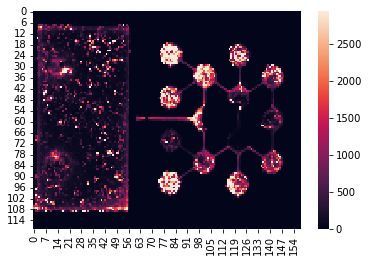

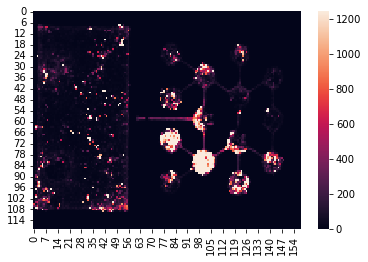

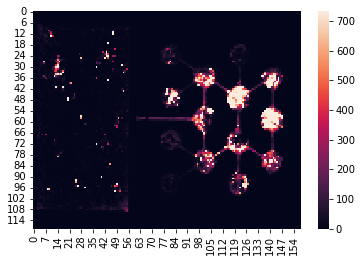

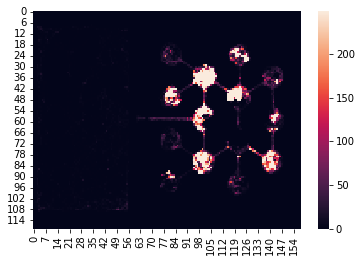

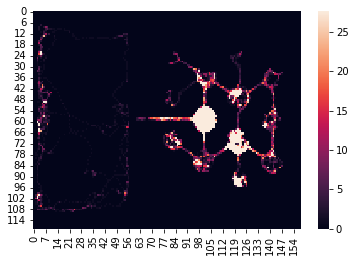

In [99]:
partition = prop_df.partition[0]

HM_part = {p: np.zeros(np.shape(HM_stack[0])) for p in partition.keys()}

for part_idx in range(np.max(list(partition.values()))):
    plt.figure()
    for ant in partition.keys():

        if partition[ant] == part_idx:
            HM_part[part_idx] += HM_stack[ant] 
    sns.heatmap(HM_part[part_idx], robust=True)


<AxesSubplot:>

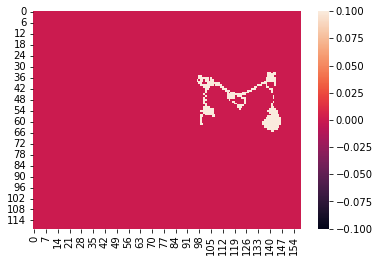

In [89]:
sns.heatmap(HM_stack[2], robust=True)

TypeError: Invalid shape (3, 119, 159) for image data

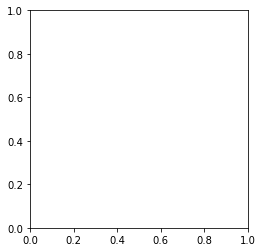

In [96]:
plt.imshow(np.array([HM_part[0], HM_part[1], HM_part[2]]))